# Valve Position Prediction Project
This project is aimed at using the behaviour of a `PID regulator` based control system obtained from `Matlab`
to predict the opening level of the actuating mechanism (i.e. the valve) through various regressors such as `RandomForestRegressor` and `CatBoostRegressor`.
## 1. Problem definition
> How well can a valve's position be predicted using the data obtained from a Matlab simulation of a PID based control system
## 2. Data
> We have data from Matlab-Simulink based models of a PID based liquid level control system at `training_data_from_matlab2.csv`
* The dataset has timestamps in `seconds` format.
* It has the desired input levels of the liquid in meters.
* The output liquid levels in meters as well
* The feedback: The difference the desired output (input) and the actual output.
* Opening levels of the valve in % (0-100)
### 2.1. How to format the data
* We need to check what kind of format, the data under label `Time` are in and then convert them into either datetime.seconds or int64 format
* Convert `string` datatypes to float using `pd.to_numeric(downcast = 'float')`
* Eliminate any missing data by first generating `is_missing` boolean data for each column of the input data
* Then eliminate by checking through `isna().sum()` and `_is_missing.value_counts()` and then eliminating the missing values by replacing them with `medians`
* Eliminate erronious data. I.e. liquid levels above `1.0` in `input` and `liquid_level` columns and valve opening levels above `100` in `valve_positions` by replacing them with medians.
## 3. Modelling
* Use `train_test_split()` from `sklearn` to divide the dataset into training and validation datasets.
* Use `RandomForestRegressor` to train the model using the training dataset.
* Use `CatBoostRegressor` to train the model using the training dataset.
* Use `RandomizedSearchCV` to get the optimize the model using the best hyperparameters `RandomForestRegressor`
* Use `catboostcv` to obtain best hyperparameters for `CatBoostRegressor`
* Evaluate the optimized model on the validation datasets.
* Use test datasets to check the predictions of the model against true labels.
## 4. Saving the model for export and reuse
At this step, we will save the model. 
* Use the `pickle` module to save the models
* Or the `joblib` module to save the models.
  
## 5. Applying the output of the model on the transfer function of the control object
* This purpose can be achieved using the `control` library.
* Use the `control` library to simulate the output liquid level due to the valve opening levels predicted by the models in step 3. 



## 2. Data preparation
* In this part, we are going to import `training_data_from_matlab6.csv`.
* Check out what kind of format, the `Time` data is in and convert it into either int64 or `datetime(format = "seconds")`
* After that, we are to check for any other `string` type data using `pd.api.dtypes.is_string_dtype()` function. And convert all string type data to numeric, using`pd.to_numeric(downcast='float')`
* After converting all of the content of the dataframe except for *DateTime* we will check for missing data using `pd.isnull()`
* If found, then the missing data is to be replaced by zero.
* Once missing data is filled, we will be checking for values more than 100 in `Valve_positions` and values more than 1000 in `Liquid_levels`.
* This is errroneous data and it is to be replaced by the median values of the above mentioned labels.
* We will make a copy of the preprocessecd dataframe and label it as `df_for_modelling`
* In `df_for_modelling`, we will extract the year, month, date, hour, minute and seconds data from the DateTime column and then drop the datetime column as it can't be used for training a Regressor model.
* We are ready for modelling!

### Importing the libraries

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import pickle
from joblib import load, dump
%matplotlib inline

### Importing the data and modifying it for fitting into a Regression model

In [2]:
df_raw_2 = pd.read_csv("training_data_from_matlab6.csv", low_memory=False)
# Make a copy of the raw dataframe before going on with something else
df_modified_data = df_raw_2.copy()
df_modified_data.info()
df_modified_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             25853 non-null  object 
 1   Input            25853 non-null  float64
 2   Liquid_levels    25853 non-null  float64
 3   Feedback         25853 non-null  float64
 4   Valve_Positions  25853 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1010.0+ KB


,Time,Input,Liquid_levels,Feedback,Valve_Positions
0,0 sec,0.0,0.000000e+00,0.000000,0.000000
1,250 sec,0.0,0.000000e+00,0.000000,0.000000
2,250 sec,0.8,0.000000e+00,0.800000,66.417308
3,250 sec,0.8,1.394661e-13,0.800000,66.417308
4,252.34 sec,0.8,1.860182e-01,0.613982,82.258628


In [3]:
# Let's try converting this Time column to datetime/timedelta
df_modified_data["Time"] = df_modified_data["Time"].str.replace(" sec", "", regex=True)


In [4]:
# Now that the data under the column "Time" can now probably be converted to numeric dtypes
df_modified_data["Time"] = pd.to_numeric(df_modified_data["Time"])

In [5]:
df_modified_data["TimeDelta"] = pd.to_timedelta(df_modified_data.Time, unit = 's')

In [6]:
df_modified_data.head()

,Time,Input,Liquid_levels,Feedback,Valve_Positions,TimeDelta
0,0.00,0.0,0.000000e+00,0.000000,0.000000,0 days 00:00:00
1,250.00,0.0,0.000000e+00,0.000000,0.000000,0 days 00:04:10
2,250.00,0.8,0.000000e+00,0.800000,66.417308,0 days 00:04:10
3,250.00,0.8,1.394661e-13,0.800000,66.417308,0 days 00:04:10
4,252.34,0.8,1.860182e-01,0.613982,82.258628,0 days 00:04:12.340000


In [7]:
df_modified_2 = df_modified_data.copy()

In [8]:
df_modified_2.drop("TimeDelta", axis = 1, inplace = True)

In [9]:
df_modified_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             25853 non-null  float64
 1   Input            25853 non-null  float64
 2   Liquid_levels    25853 non-null  float64
 3   Feedback         25853 non-null  float64
 4   Valve_Positions  25853 non-null  float64
dtypes: float64(5)
memory usage: 1010.0 KB


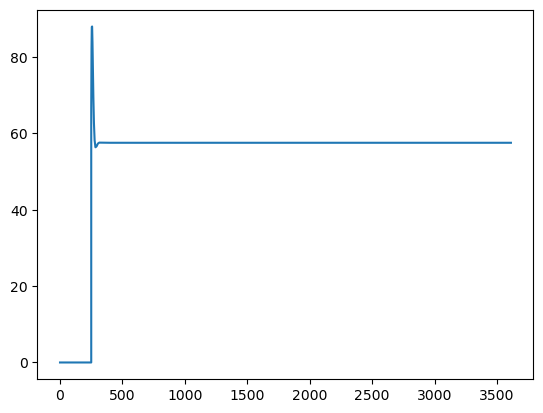

In [10]:
fig, ax = plt.subplots()
ax.plot(df_modified_2.Time[:300], df_modified_2.Valve_Positions[:300]);

In [11]:
# We know that all of these are numeric dtypes but still we will check for any string dtype remaining
for label, content in df_modified_2.items():
    if pd.api.types.is_string_dtype(content):
        print("There are string types in: ", label)
    else:
        print("There are no strings in :", label)

There are no strings in : Time
There are no strings in : Input
There are no strings in : Liquid_levels
There are no strings in : Feedback
There are no strings in : Valve_Positions


In [12]:
# Check for invalid/empty data
for label, content in df_modified_2.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print("There are NaNs in: ", label)
            df_modified_2[label + "is_missing"] = pd.isnull(content)
            df_modified_2[label] = content.fillna(0)
        else:
            print("There are no missing values in: ", label)
        

There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions


In [13]:
# Check for erroneous data in Liquid_levels
for content in df_modified_2.Liquid_levels:
    if (content > 1.25):
        print("Erroneous value found! ", content)
        content = df_modified_2.Liquid_levels.median()

# Check for erroneous data in Valve_positions
for content in df_modified_2.Valve_Positions:
    if (content > 100.0):
        print("Erroneous data found! ", content)
        content = df_modified_2.Valve_Positions.median()
np.max(df_modified_2.Liquid_levels), np.max(df_modified_2.Valve_Positions)    

(0.862643337266345, 88.0234256553024)

## 3. Modelling
* At this stage, a model based on `RandomForestRegressor` is to be created
* Next, the target variable will be separated from the others to create `X` and `y` datasets
* Here, the `Valve_Positions` column of our dataset is the target variable, to be predicted. It will be placed in the dataframe `y`
* All the other variables i.e. `Time`, `Input`, `Liquid_levels` and `Feedback` will be placed in `X`
* Next, X and y will be divided into training and validation sets using `train_test_split`
* After that the model will be fitted with `X_train and y_train`, its effectiveness will be checked with the validation datasets
* The model will then be optimized using `RandomizedSearchCV` to see if its effectiveness can be improved upon. 

In [14]:
# We are prepared for modelling
X = df_modified_2.drop("Valve_Positions", axis = 1)
y = df_modified_2["Valve_Positions"]
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                      test_size=0.2)
model = RandomForestRegressor(n_jobs = -1,
                              random_state=45)

In [15]:
%%time
# let's try fittig once more
model.fit(X_train, y_train)

CPU times: total: 4.14 s
Wall time: 520 ms


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [16]:
val_preds = model.predict(X_val)


In [17]:
model.score(X_val, y_val)

0.3604449268392048

In [18]:
model.score(X_train, y_train)

0.966634597318917

### Optimization of the model using RandomizedSearch CV
In this step, we will be using `RandomizedSearchCV` to optimize the hyperparameters of the model


In [19]:

%%time
from sklearn.model_selection import RandomizedSearchCV
# Define the rf_grid
rf_grid = {"n_estimators": np.arange(0, 1500, 10),
           "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
           "max_depth": [None, 3, 5, 10, 15, 20],
           "min_samples_split": np.arange(2, 60, 2),
           "min_samples_leaf": np.arange(1, 30, 2),
           "max_features": [ 0.25, 0.5, 1.0, 'sqrt'],
           "max_samples": [None]}
# Create the optimized model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=45),
                               param_distributions = rf_grid,
                              n_iter = 6, 
                              cv = 5,
                              verbose = True)
# Fit the model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 12min 32s
Wall time: 1min 32s


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=45)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 3, ...], 'max_features': [0.25, 0.5, ...], 'max_samples': [None], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",6
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be

In [20]:
rs_model.best_params_

{'n_estimators': 580,
 'min_samples_split': 30,
 'min_samples_leaf': 29,
 'max_samples': None,
 'max_features': 0.5,
 'max_depth': 20,
 'criterion': 'absolute_error'}

In [21]:
rs_model.score(X_val, y_val)

0.0005754409484890477

### Preparation of a function to preprocess data
* We will train the model on the entire dataset
* We will be able to train the model on timestamps
* To make the preprocessing easier, we will develop a preprocessing function


In [22]:
# Develop a file path
FILE_PATH = "training_data_from_matlab5.csv"

def preprocess_data(PROVIDED_FILE_PATH):
    """
    This function is meant to predict the opening level of a valve on the basis of input data, feedback data and timestamps
    The data is to be imported from the datasheets as specified in "FILE_PATH"
    The file will imported to a pandas dataframe
    The time data is to be converted from string to numeric
    A check will be performed to remove string type data, which is to be converted to float type
    Then a check will be performed for any missing data
    Then erroneous data (liquid levels > 1.2 and valve positions > 100) will be replaced with the median values of the respective columns
    The dataframe will be ready for further action!
    """
    # Step-1 read data from the file path
    print("Reading data....")
    df_data = pd.read_csv(PROVIDED_FILE_PATH)
    # Step-2 change the datatype of time column from string to numeric
    # In this case, we need to remove the phrase 'sec' from the column
    print("Changing the Time data from string to numeric....")
    df_data["Time"] = df_data["Time"].str.replace(" sec","",regex=True)
    # Then we will have to change the datatype from object to numeric
    df_data["Time"] = pd.to_numeric(df_data["Time"])
    # Step-3: Check for string type data
    print("Checking for string type data....")
    for label, content in df_data.items():
        if pd.api.types.is_string_dtype(content):
            print("There is string type data in: ",label)
            print("Converting strings to float in: ", label)
            df_data[label] = pd.to_numeric(df_data[label],errors = "coerce")
        else:
            print("There are no strings in: ", label)
    # Step-4: Check for missing data
    print("Checking for missing data....")
    for label, content in df_data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                print("There are missing values in: ", label)
                df_data[label + "is_missing"] = pd.isnull(content)
                # Now fill the missing data with zeroes
                df_data[label] = content.fillna(0)
            else:
                print("There are no missing values in: ",label)
    # Step-5: Now check for erroneous data
    print("Checking for erroneous data....")
    # In this case first we will be removing any values 
    for content in df_data["Liquid_levels"]:
        if (content > 1.5):
            print("Erroneous data found")
            content = df_data["Liquid_levels"].median()
    for content in df_data["Valve_Positions"]:
        if (content > 100.0):
            print("Erroneous data found")
            content = df_data["Valve_Positions"].median()


    
    print("Preprocessing complete....")
    print(df_data.info())
    return df_data
            

In [23]:
df_data2=preprocess_data(FILE_PATH)

Reading data....
Changing the Time data from string to numeric....
Checking for string type data....
There are no strings in:  Time
There are no strings in:  Input
There are no strings in:  Liquid_levels
There are no strings in:  Feedback
There are no strings in:  Valve_Positions
Checking for missing data....
There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions
Checking for erroneous data....
Preprocessing complete....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             9021 non-null   float64
 1   Input            9021 non-null   float64
 2   Liquid_levels    9021 non-null   float64
 3   Feedback         9021 non-null   float64
 4   Valve_Positions  9021 non-nu

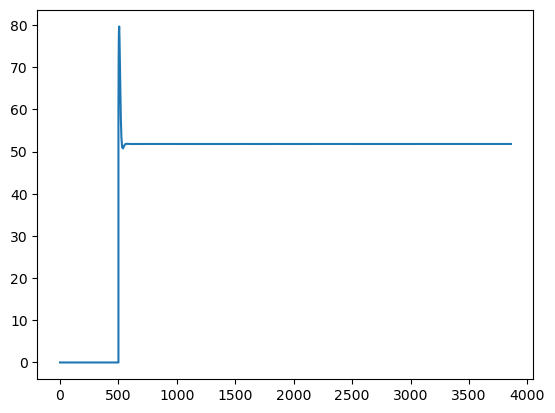

In [24]:
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:300], df_data2.Valve_Positions[:300]);

In [25]:
# Create a test data set
X_test = df_data2.drop("Valve_Positions", axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           9021 non-null   float64
 1   Input          9021 non-null   float64
 2   Liquid_levels  9021 non-null   float64
 3   Feedback       9021 non-null   float64
dtypes: float64(4)
memory usage: 282.0 KB


In [26]:
y_preds = model.predict(X_test)

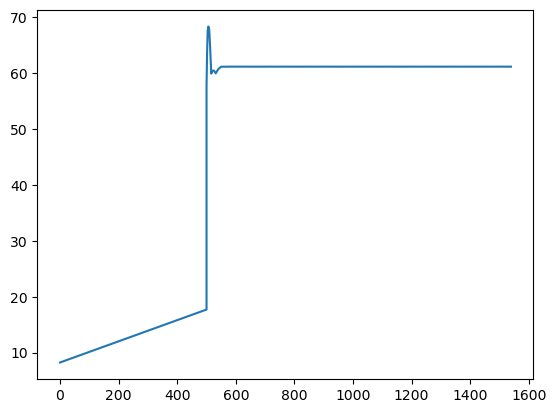

In [27]:
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:100], y_preds[:100]);

In [28]:
y_true = df_data2["Valve_Positions"]

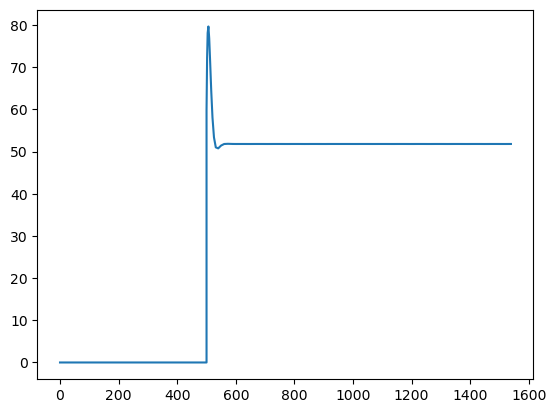

In [29]:
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:100], y_true[:100]);

In [30]:
# Let's try using the rs_model too and see how it performs
y_preds_rs = rs_model.predict(X_test)

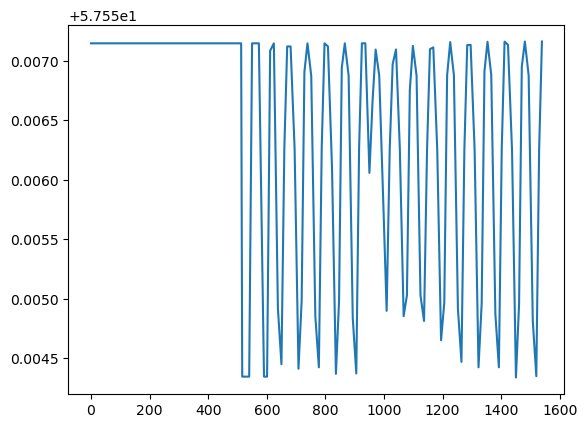

In [31]:
# Plot the output of rs_model
fig,ax = plt.subplots()
ax.plot(df_data2.Time[:100], y_preds_rs[:100]);

## 4. Saving the model for further use and exporting 
The initial and the RandomizedSearchCV based model will be saved using both `pickle` and `joblib` libraries

In [32]:

# Save an existing model to file
# pickle.dump(model, open("rf_regressor_valve_position_predictor_6.pkl", "wb"))


In [33]:
# Lets try to see if our loaded model worked or not
loaded_pickle_model_6 = pickle.load(open("rf_regressor_valve_position_predictor_6.pkl","rb"))

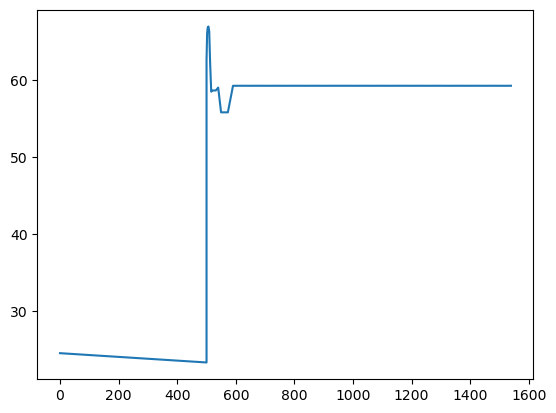

In [34]:
pickle_y_preds = loaded_pickle_model_6.predict(X_test)
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:100], pickle_y_preds[:100]);

In [35]:
# Let's save the RandomizedSearchCV model with joblib

# Save the rs optimized model to a file
# dump(rs_model, filename="rs_optimized_valve_position_predictor_1.joblib")

C:\Users\anshu\anaconda3\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\anshu\anaconda3\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\anshu\anaconda3\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.7.2 when using version 1.8.0. This migh

0.8086849595229533


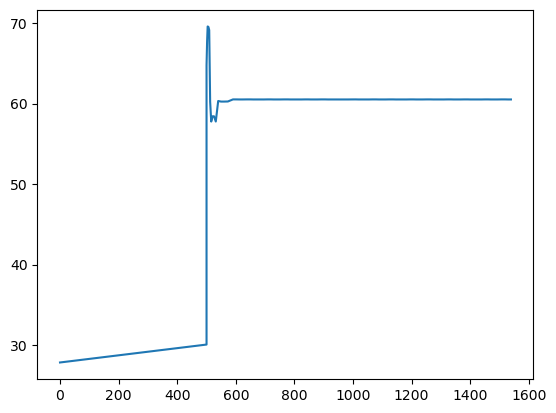

In [36]:
# Import a saved joblib model
loaded_rs_model = load(filename="rs_optimized_valve_position_predictor_1.joblib")
print(loaded_rs_model.score(X_val, y_val))
loaded_rs_y_preds = loaded_rs_model.predict(X_test)
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:100], loaded_rs_y_preds[:100]);

## 5. Applying the output of the model on the transfer function of the control object

In [37]:
# Lets try to use the control library
# The transfer function of the control object is 1.23/12.04S+1
# Numerator is [1.23], denominator is [12.04,1]
num = [1.23]
den = [12.04,1]
W_object = ct.tf(num,den)
W_object

TransferFunction(array([1.23]), array([12.04,  1.  ]))

In [38]:
 # let's try to plot the forced response
time_vector = np.linspace(0, 10500, df_data2.Time.size)
time_returned2, sysout = ct.forced_response(0.0113*W_object, time_vector, pickle_y_preds)
time_returned3, sysout2 = ct.forced_response(0.0113*W_object, time_vector, y_true)

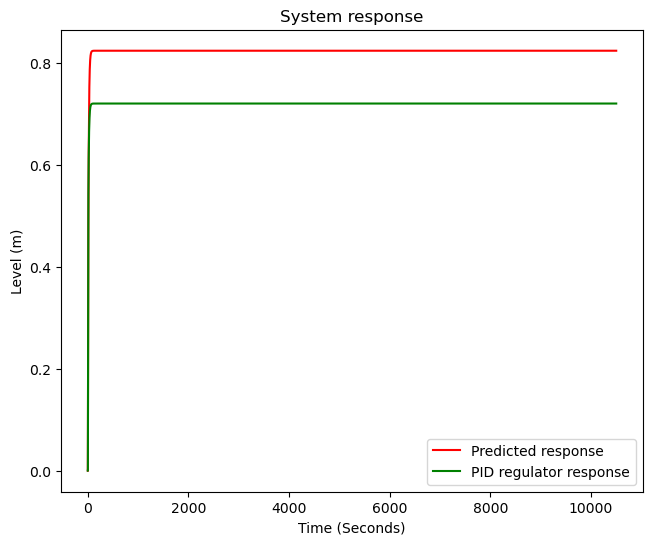

In [39]:
fig, ax2 = plt.subplots(figsize=(7.5,6))
ax2.plot(time_returned2,
        sysout, c = 'r', label = "Predicted response")
ax2.plot(time_returned2, sysout2, c = 'g', label = "PID regulator response")
ax2.set(title="System response",
        xlabel="Time (Seconds)",
        ylabel="Level (m)")
ax2.legend();


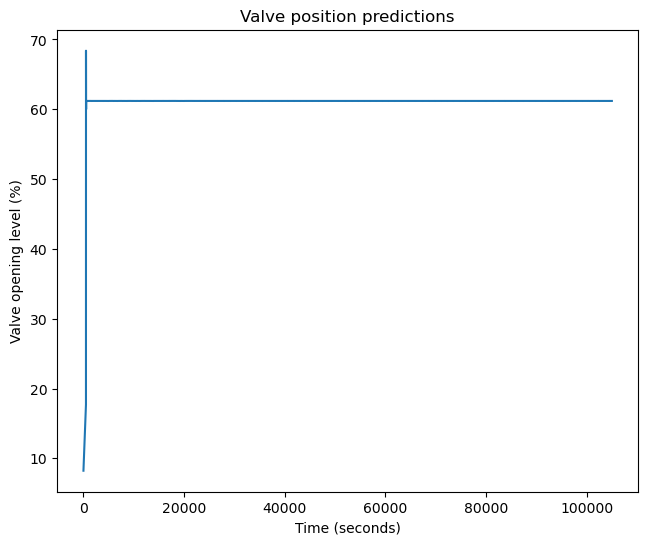

In [40]:
fig, ax3 = plt.subplots(figsize=(7.5,6))
ax3.plot(df_data2.Time, y_preds)
ax3.set(xlabel = "Time (seconds)",
        ylabel = "Valve opening level (%)",
        title = "Valve position predictions");

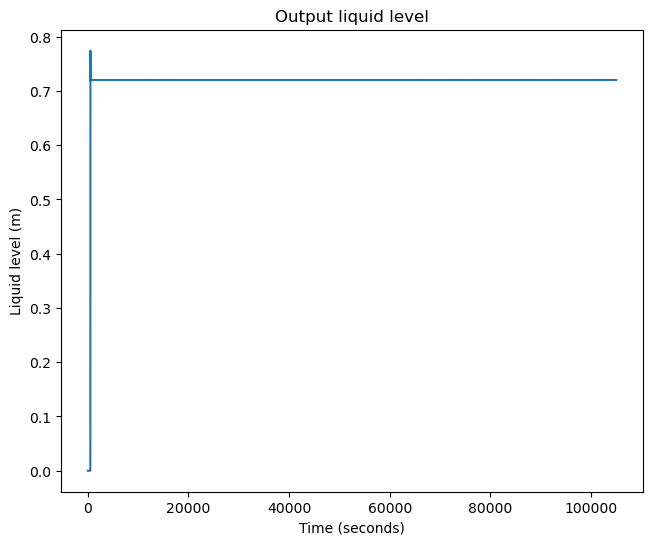

In [41]:
fig, ax4 = plt.subplots(figsize=(7.5,6))
ax4.plot(df_data2.Time, df_data2.Liquid_levels)
ax4.set(xlabel = "Time (seconds)",
        ylabel = "Liquid level (m)",
        title = "Output liquid level");

## 6. Improvisation: 

In order to improvise the model, we can take the following steps: 
1. Use a larger dataset to train the model.  
2. Use a different machine learning regressor (In this case, we will be trying out `catboost_regressor`)

### 6.1. Improvisation using a larger dataset

A dataset with larger number of samples has been prepared at `training_data_from_matlab7.csv`. 
* The function `preprocess_data()` is to be used to preprocess the data.
* Then a `RandomForestRegressor` based model will be trained on the preprocessed data
* Next, the preprocessing function is to be used once again to preprocess validation data at `training_data_from_matlab_8.csv`
* The model is to be tested on this validation data

In [42]:
# Use the preprocess data function to preprocess the data from training_data_from_matlab7.csv
FILE_PATH_2 = "training_data_from_matlab7.csv"
df_data3 = preprocess_data(FILE_PATH_2)

Reading data....
Changing the Time data from string to numeric....
Checking for string type data....
There are no strings in:  Time
There are no strings in:  Input
There are no strings in:  Liquid_levels
There are no strings in:  Feedback
There are no strings in:  Valve_Positions
Checking for missing data....
There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions
Checking for erroneous data....
Preprocessing complete....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25474 entries, 0 to 25473
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             25474 non-null  float64
 1   Input            25474 non-null  float64
 2   Liquid_levels    25474 non-null  float64
 3   Feedback         25474 non-null  float64
 4   Valve_Positions  25474 non

In [43]:
def prepare_for_modelling(DataFrame):
    """
    Function to prepare the data for fitting into the model
    Takes a dataframe as input. Drops the Valve_positions data for X and Valve_positions data is used as y
    X and y are returned
    """
    X = DataFrame.drop("Valve_Positions", axis = 1)
    y = DataFrame["Valve_Positions"]
    return X,y

In [44]:
X2,y2 = prepare_for_modelling(df_data3)

In [45]:
# Split the data into training and validation sets
X2_train, X2_val,y2_train, y2_val = train_test_split(X2, y2, test_size = 0.25) 

In [46]:
# Prepare the model
model_2 = RandomForestRegressor(n_jobs=-1,
                                criterion = "absolute_error",
                                random_state=45)

In [47]:
%%time 
# Fit the model
model_2.fit(X2_train, y2_train)

CPU times: total: 23.7 s
Wall time: 2.58 s


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'absolute_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [48]:
# Try to evaluate the model
model_2.score(X2_val, y2_val)

0.9992626782422778

Now let's test the model on a test data set
* In order to test the model, a test data set is present at `training_data_from_matlab8.csv`
* Preprocess that data to a new dataframe
* Have the model predict on the data and evaluate the predictions against the true labels


In [49]:
# preprocess the test data set
FILE_PATH_3 = "training_data_from_matlab8.csv"
df_test_data_2 = preprocess_data(FILE_PATH_3)

Reading data....
Changing the Time data from string to numeric....
Checking for string type data....
There are no strings in:  Time
There are no strings in:  Input
There are no strings in:  Liquid_levels
There are no strings in:  Feedback
There are no strings in:  Valve_Positions
Checking for missing data....
There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions
Checking for erroneous data....
Preprocessing complete....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20376 entries, 0 to 20375
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             20376 non-null  float64
 1   Input            20376 non-null  float64
 2   Liquid_levels    20376 non-null  float64
 3   Feedback         20376 non-null  float64
 4   Valve_Positions  20376 non

In [50]:
X2_test, y2_test = prepare_for_modelling(df_test_data_2)

In [51]:
%%time
# Now that the test data is prepared, get the model to predict on the test data
y2_preds = model_2.predict(X2_test)

CPU times: total: 109 ms
Wall time: 70.6 ms


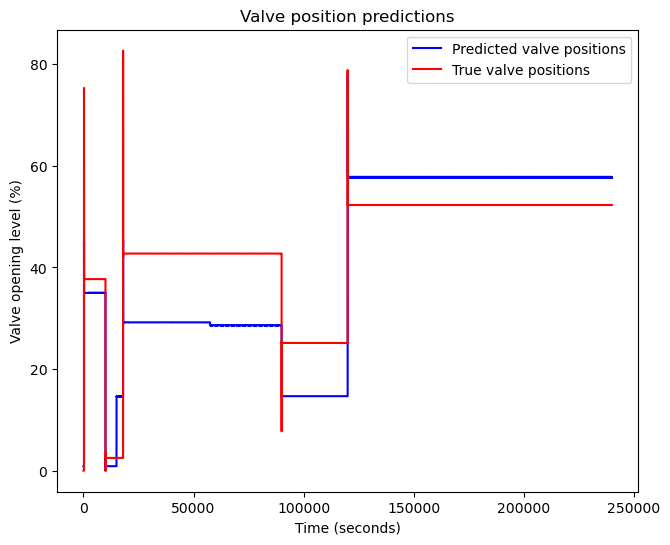

In [52]:
fig, ax8 = plt.subplots(figsize=(7.5,6))
ax8.plot(df_test_data_2.Time, y2_preds, c = "blue", label = "Predicted valve positions")
ax8.plot(df_test_data_2.Time, y2_test, c = "red", label = "True valve positions")
ax8.set(xlabel = "Time (seconds)",
        ylabel = "Valve opening level (%)",
        title = "Valve position predictions")
ax8.legend();

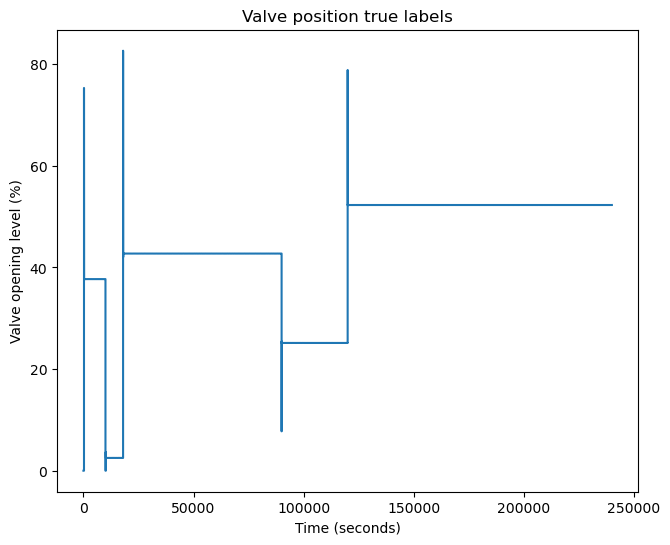

In [53]:
fig, ax9 = plt.subplots(figsize=(7.5,6))
ax9.plot(df_test_data_2.Time, y2_test)
ax9.set(xlabel = "Time (seconds)",
        ylabel = "Valve opening level (%)",
        title = "Valve position true labels");

In [54]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [55]:
mean_absolute_error(y2_test, y2_preds) 

8.49627382045884

In [56]:
mean_squared_error(y2_test, y2_preds)

88.6233461722164

In [57]:
# Try to plot the output of the transfer function
num = [1.76]
den = [14.39,1]
W_object_2 = ct.tf(num,den)
W_object_2

TransferFunction(array([1.76]), array([14.39,  1.  ]))

In [58]:
# Try to plot the response for the liquid 

In [59]:
time_vector = np.linspace(0, 20376, df_test_data_2.Time.size)
time_returned3, sysout2 = ct.forced_response(0.0113*W_object_2, time_vector, y2_preds) # Predicted liquid levels as per transfer function
time_returned4, sysout3 = ct.forced_response(0.0113*W_object_2, time_vector, y2_test)

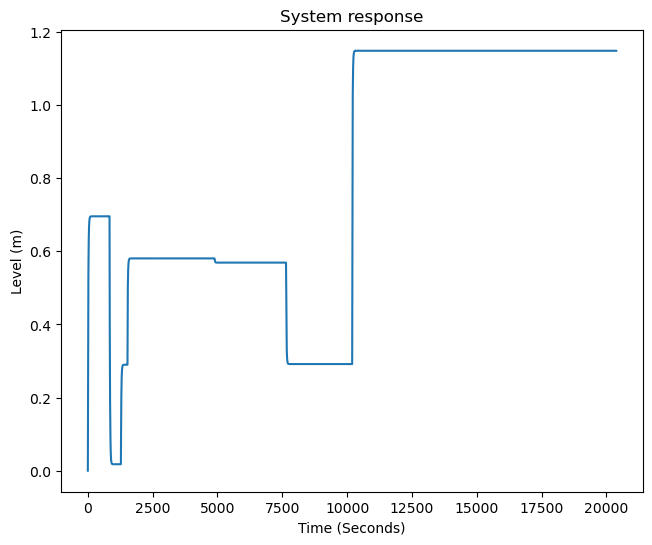

In [60]:
fig, ax10 = plt.subplots(figsize=(7.5,6))
ax10.plot(time_returned3,
        sysout2)

ax10.set(title="System response",
        xlabel="Time (Seconds)",
        ylabel="Level (m)");

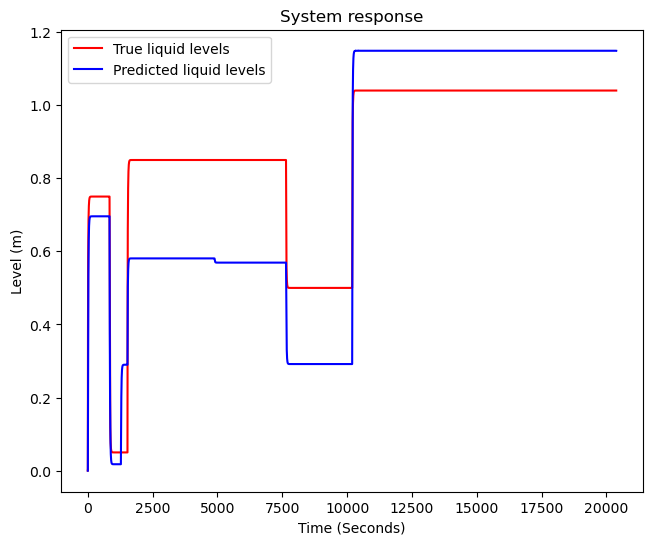

In [61]:
fig, ax11 = plt.subplots(figsize=(7.5, 6))
ax11.plot(time_returned4, sysout3, color = 'r', label = "True liquid levels")
ax11.plot(time_returned3, sysout2, color = 'b', label = "Predicted liquid levels")
ax11.set(title="System response",
        xlabel="Time (Seconds)",
        ylabel="Level (m)")
ax11.legend();

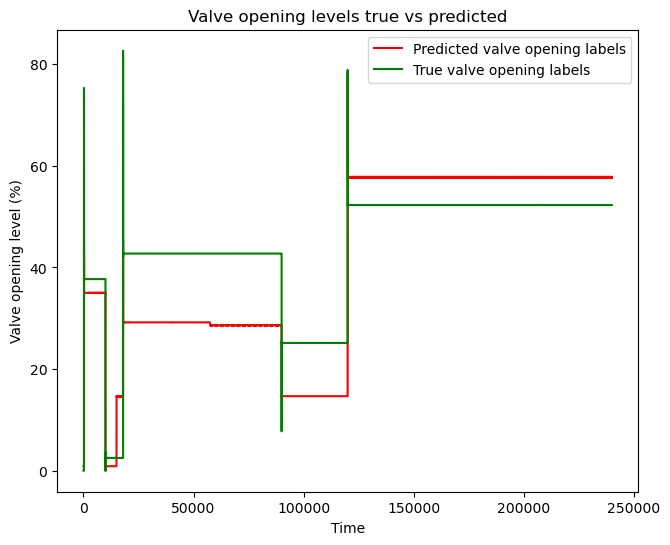

In [62]:
# Superimpose the predicted valve_opening levels upon the true labels
fig, ax12 = plt.subplots(figsize =  (7.5,6))
ax12.plot(df_test_data_2.Time, y2_preds, color = 'r', label = "Predicted valve opening labels")
ax12.plot(df_test_data_2.Time, y2_test, color = 'g', label = "True valve opening labels")
ax12.set(xlabel = "Time",
         ylabel = "Valve opening level (%)",
         title = "Valve opening levels true vs predicted")
ax12.legend();
                         

Obtaining `feature_importance` for `model_2`
Create a function to plot the feature importances of the model, predicting valve position for liquid leel control system

In [63]:
def plot_feature_importances(model):
    """
    Create a small dataframe providing the feature importances of the various features in the features dataframe of a model.
    Takes the model and features dataframe as input.
    """
    df_feature_importances = pd.DataFrame(model.feature_importances_, index=["Time", "Input", "Liquid_levels", "Feedback"])
    return df_feature_importances

In [64]:
model_2.feature_importances_

array([0.13530964, 0.85835787, 0.00441293, 0.00191956])

In [65]:
X2.columns

Index(['Time', 'Input', 'Liquid_levels', 'Feedback'], dtype='object')

In [66]:
model_2_feature_importances = plot_feature_importances(model_2)
model_2_feature_importances

,0
Time,0.135310
Input,0.858358
Liquid_levels,0.004413
Feedback,0.001920


### Improvisation using rf_grid
The above model has shown some improvement due to using a larger training dataset, however more improvements can be made using the `RandomizedSearchCV`. 

In [67]:
# Prepare the RF_grid
rf_grid_2 = {"n_estimators": np.arange(0, 1500, 10),
           "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
           "max_depth": [None, 3, 5, 10, 15, 20],
           "min_samples_split": np.arange(2, 60, 2),
           "min_samples_leaf": np.arange(1, 30, 2),
           "max_features": [0.25, 0.5, 1.0, 'sqrt'],
           "max_samples": [None]}

# Prepare the rs_model
rs_model_2 = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, 
                                                     random_state=45),
                                param_distributions=rf_grid_2,
                                n_iter=6,
                                cv = 5,
                                verbose = True)

                                

In [68]:
%%time
# Fit the model
rs_model_2.fit(X2_train, y2_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 7min 36s
Wall time: 1min 22s


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=45)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 3, ...], 'max_features': [0.25, 0.5, ...], 'max_samples': [None], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",6
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be

In [69]:
rs_model_2.best_params_

{'n_estimators': 1480,
 'min_samples_split': 36,
 'min_samples_leaf': 3,
 'max_samples': None,
 'max_features': 'sqrt',
 'max_depth': 3,
 'criterion': 'friedman_mse'}

In [70]:
rs_model_2.score(X2_val, y2_val)

0.9953883194635736

In [71]:
rs_y2_preds = rs_model_2.predict(X2_test)
mean_absolute_error(y2_test, rs_y2_preds)

5.754537622829497

The improvised model with `RandomizedSearchCV` shows a certain degree of improvement considering the `mean_absolute_error` 


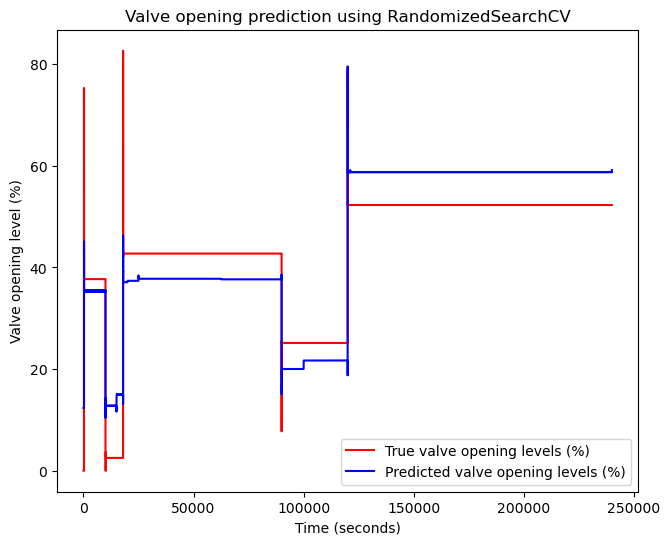

In [72]:
# Plotting the system output for rs_model_2
fig, ax15 = plt.subplots(figsize = (7.5,6))
ax15.plot(df_test_data_2.Time, y2_test, c = 'red', label = "True valve opening levels (%)")
ax15.plot(df_test_data_2.Time, rs_y2_preds, c = 'blue', label = "Predicted valve opening levels (%)")
ax15.set(xlabel = "Time (seconds)",
         ylabel = "Valve opening level (%)",
         title = "Valve opening prediction using RandomizedSearchCV")
ax15.legend();

## 7. Improvisation step-2

At this stage, the independent labels is to be changed to only the `feedback` labels. The dependent label remains as the `Valve_positions`. 
* Both labels are to be obtained from the `df_test_data_2` database for training
* The test data is to be obtained from the `df_data2` database


### 7.1. Improvisation step-2: Preparing the training and test data


In [73]:
# Preparing input labels 
X3_train = df_test_data_2.Feedback # Feedback is the only independent variable in this case
y3_train = df_test_data_2.Valve_Positions # Valve positions is the target variable
X3_train = pd.DataFrame(X3_train) # Reshaping the X3_train to provide a 2D array instead of a 1-D array for fitting

In [74]:
X3_train.shape

(20376, 1)

In [75]:
model_3 = RandomForestRegressor(n_jobs = -1,
                                criterion = "absolute_error",
                                random_state=45)


In [76]:
%%time
# Time and fit the model
model_3.fit(X3_train, y3_train)

CPU times: total: 12.4 s
Wall time: 1.45 s


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'absolute_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [77]:
# Form the test datasets
X3_test = df_data2.Feedback
y3_test = df_data2.Valve_Positions


In [78]:
y3_preds = model_3.predict(pd.DataFrame(X3_test))

In [79]:
mean_absolute_error(y3_preds, y3_test)

9.50325737269614

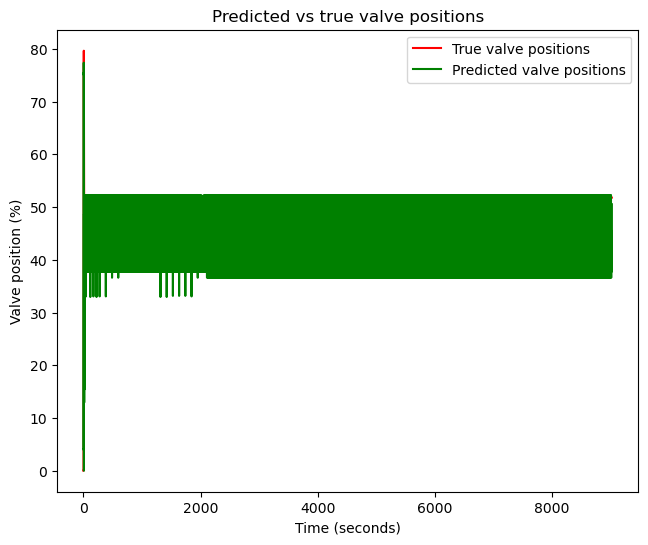

In [80]:
# Plot the predicted labels vs the true labels 
fig, ax13 = plt.subplots(figsize = (7.5, 6))
ax13.plot(y3_test, color = 'r', label = "True valve positions")
ax13.plot(y3_preds, color = 'g', label = "Predicted valve positions")
ax13.set(xlabel = "Time (seconds)",
         ylabel = "Valve position (%)",
         title = "Predicted vs true valve positions")
ax13.legend();

In [81]:
# Try to force this value upon the transfer function
time_vector_2 = np.linspace(0,10500, df_data2.Time.size)
time_returned_5, sysout4 = ct.forced_response(0.0113*W_object, time_vector_2, y3_test)
time_returned_6, sysout5 = ct.forced_response(0.0113*W_object, time_vector_2, y3_preds)

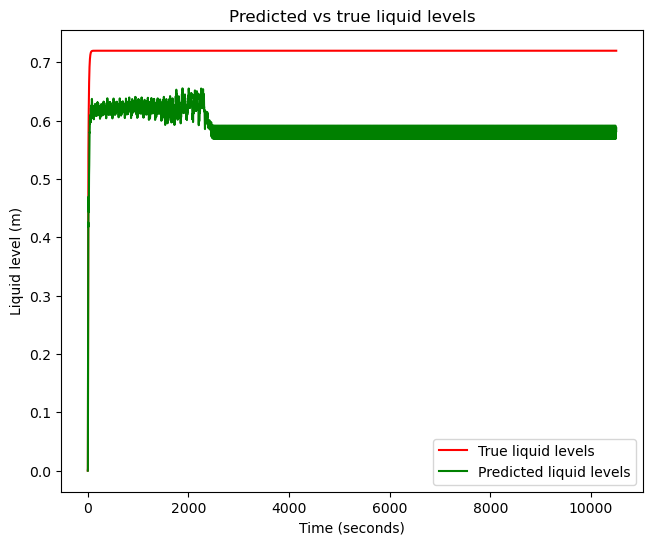

In [82]:
# Plot the system output
fig, ax14 = plt.subplots(figsize = (7.5, 6))
ax14.plot(time_returned_5, sysout4, color = 'r', label = "True liquid levels")
ax14.plot(time_returned_5, sysout5, color = 'g', label = "Predicted liquid levels")
ax14.set(xlabel = "Time (seconds)",
         ylabel = "Liquid level (m)",
         title = "Predicted vs true liquid levels")
ax14.legend();

### 7.2 Improvisation using RandomizedSearchCV

In [83]:
# Prepare the the rf_grid 
rf_grid_3 = {"n_estimators": np.arange(0,2000,10),
            "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
            "max_depth": [None, 3, 5, 10, 15, 20],
            "min_samples_split": np.arange(2, 60, 2),
            "min_samples_leaf": np.arange(1,30,2),
            "max_features": [0.25, 0.5, 1.0, 'sqrt'],
            "max_samples":[None, 5000, 10000]}
# Create the RandomizedSearchCV
rs_model_3 = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                      random_state = 45),
                                param_distributions=rf_grid_3,
                                n_iter = 6, 
                                cv = 5,
                                verbose = True)

# Fit the model 
rs_model_3.fit(X3_train, y3_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=45)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['squared_error', 'absolute_error', ...], 'max_depth': [None, 3, ...], 'max_features': [0.25, 0.5, ...], 'max_samples': [None, 5000, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",6
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies 

In [84]:
# Get the prediction labels for the test data
rs_y3_preds = rs_model_3.predict(pd.DataFrame(X3_test))

In [85]:
# Get the mean absolute error between the true and predicted labels 
mean_absolute_error(y3_test, rs_y3_preds)

9.989069302531222

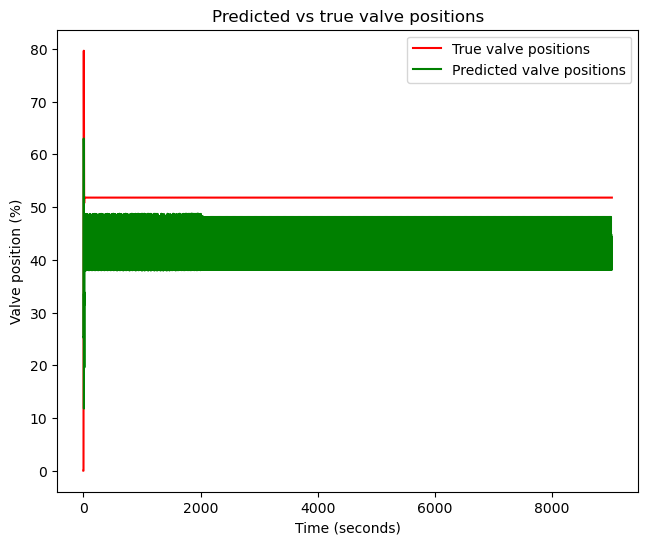

In [86]:
# Plot the predicted valve opening levels vs. the true valve opening levels
fig, ax15 = plt.subplots(figsize = (7.5, 6))
ax15.plot(y3_test, color = 'r', label = "True valve positions")
ax15.plot(rs_y3_preds, color = 'g', label = "Predicted valve positions")
ax15.set(xlabel = "Time (seconds)",
         ylabel = "Valve position (%)",
         title = "Predicted vs true valve positions")
ax15.legend();

In [87]:
# Prepare the predicted liquid levels based on the predicted valve opening levels 
time_returned_7, sysout6 = ct.forced_response(0.0113*W_object, time_vector_2, y3_test)
time_returned_8, sysout7 = ct.forced_response(0.0113*W_object, time_vector_2, rs_y3_preds)

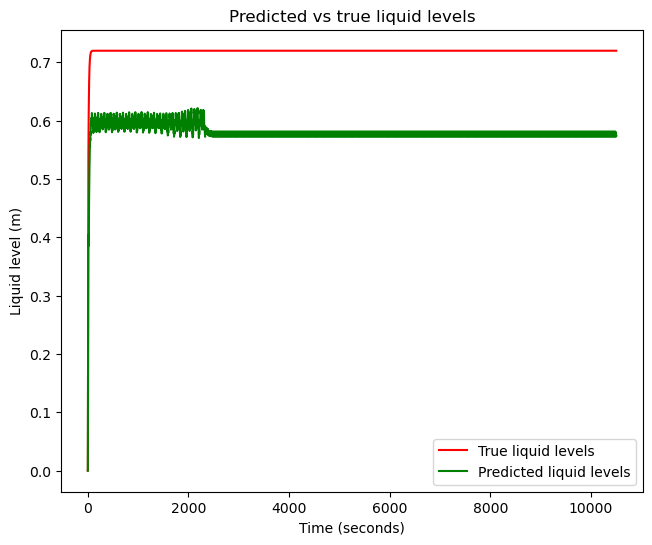

In [88]:
# Plot the system output
fig, ax16 = plt.subplots(figsize = (7.5, 6))
ax16.plot(time_returned_7, sysout6, color = 'r', label = "True liquid levels")
ax16.plot(time_returned_8, sysout7, color = 'g', label = "Predicted liquid levels")
ax16.set(xlabel = "Time (seconds)",
         ylabel = "Liquid level (m)",
         title = "Predicted vs true liquid levels")
ax16.legend();